# Strategies for line thickness variation

By [Allison Parrish](https://www.decontextualize.com/)

From a mathematical perspective, lines are one-dimensional: they technically have no thickness. Of course, a line that is manifest in the world, as a mark on a surface, necessarily has thickness: the width of the line of pixels on the screen, for example, or the width of the ink left on the paper by the pen plotter. It's often the case, however, that we want to represent a figure as a line, or as a sequence of connected lines (a polyline), but then manifest that line (or polyline) on the surface with some variation in thickness along its length. One reason to do this is to mimic the quality of lines that are drawn with various physical writing implements—e.g., to imitate the writing from a fountain pen, or an ink brush.

This notebook relates some strategies for achieving effects like this, using only the line drawing tools in [vsketch](https://vsketch.readthedocs.io/en/latest/index.html).

## Preliminaries

First, import the necessary libraries, including vsketch, Bezmerizing, and a few handy things from numpy:

In [1]:
import vsketch
from bezmerizing import Polyline
import math
import random
from numpy.random import uniform
import numpy as np

In the following cell, I've defined a simple four-segment figure to be used as a polyline:

In [2]:
pts = [[-42, -42],
       [-38,  18],
       [-10, -10],
       [ 18,  18],
       [ 22, -42]]

Here's what it looks like when we draw it:

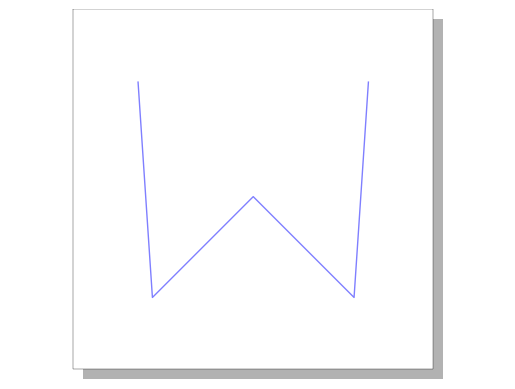

In [3]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(pts)
vsk.display()

To make the figure a little more interesting and writing-like, I calculate a spline through these points using Bezmerizing's `catmull_spline()` method, then convert it back to a polyline.

In [4]:
curve_pline = Polyline(pts).augment().catmull_spline().to_polyline(20)

Here's what the resulting polyline looks like. (You can hide the original polyline by commenting out the line that draws it.)

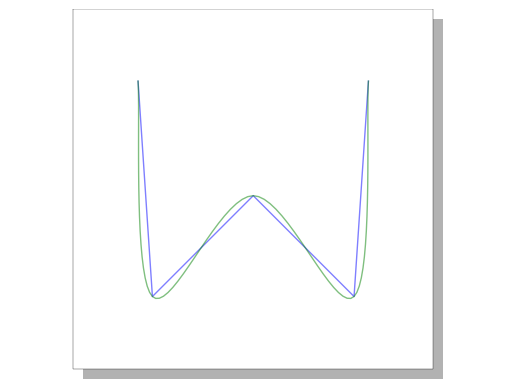

In [5]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(pts) # comment this line out to hide original polyline
vsk.stroke(2)
vsk.polygon(curve_pline)
vsk.display()

## Overlaid strokes

The first and simplest strategy for creating the impression of thickness is simply to *draw the line multiple times with a small linear offset*. To illustrate this technique, let's first draw the curve:

In [6]:
curve_pline = Polyline(pts).augment().catmull_spline().to_polyline(20)

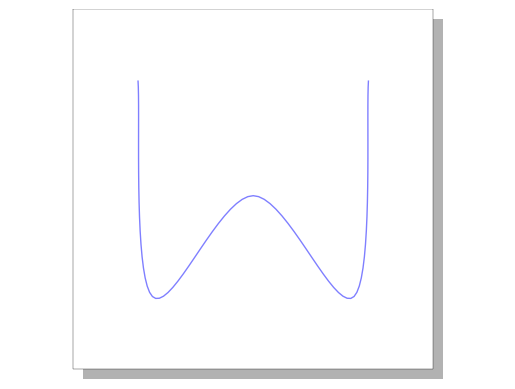

In [7]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(curve_pline)
vsk.display()

And then draw the same curve, offset by 5mm:

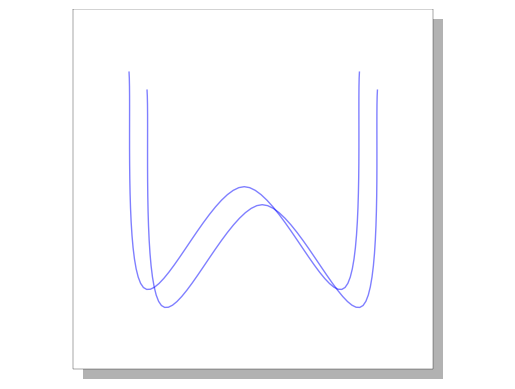

In [8]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(curve_pline)
with vsk.pushMatrix():
    vsk.translate(5, 5)
    vsk.polygon(curve_pline)
vsk.display()

To make this look like a thicker line, we'll draw several *intermediate* curves between the first and the second, using a `for` loop, like so:

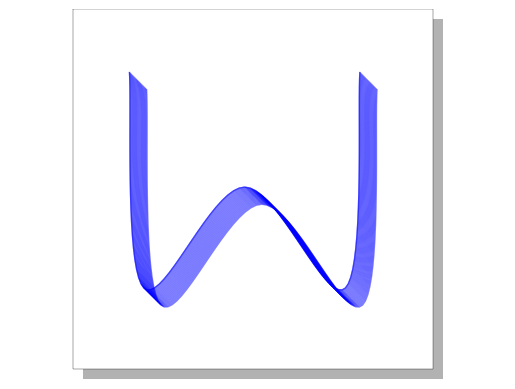

In [9]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(curve_pline)
for i in range(20):
    with vsk.pushMatrix():
        vsk.translate(i*0.25, i*0.25)
        vsk.polygon(curve_pline)
vsk.display()

You can see that we've made a figure that looks sort of like it was drawn using a pen with its nib at a 45 degree angle. You can change the thickness and orientation of the "nib" by changing the multiplier in the parameters to `.translate()` and the number of loop iterations, like so:

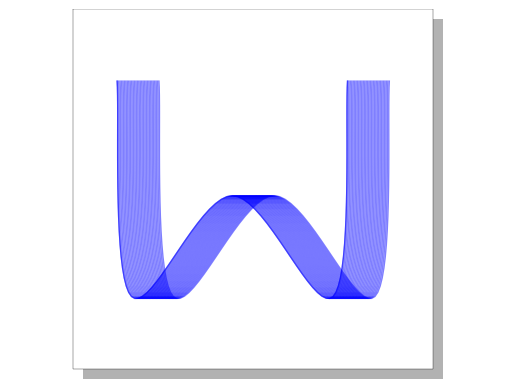

In [10]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(curve_pline)
for i in range(30):
    with vsk.pushMatrix():
        vsk.translate(i*0.4, 0)
        vsk.polygon(curve_pline)
vsk.display()

The following example takes this one step further, introducing some randomness in both scale and position, which produces an effect similar to a dry paintbrush:

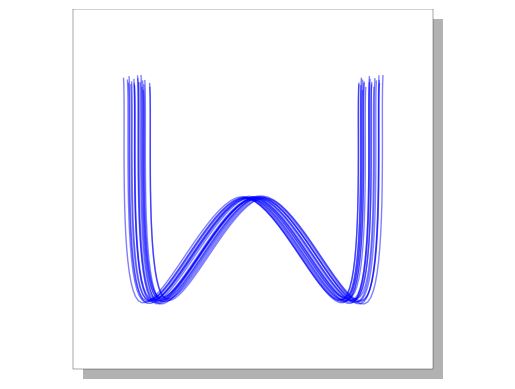

In [11]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.polygon(curve_pline)
for i in range(20):
    with vsk.pushMatrix():
        vsk.scale(uniform(0.95, 1.05))
        vsk.translate((i+uniform(-0.5, 0.5))*0.3, 0)
        vsk.polygon(curve_pline)
vsk.display()

When you draw these examples with the pen plotter, the thickness of the pen you're using will matter! You may have to use a thicker pen to create the impression of a single solid stroke, instead of a sequence of smaller strokes. (Although the impression of a sequence of smaller strokes might be desirable, as in the dry paintbrush simulation above!)

## Curve normal offsets

Another related way of creating the impression of line thickness is to overlay multiple lines that are derived from offsets of the curve's normals. The normals of a curve are vectors at a right angle to the curve's tangent; by multiplying these normals, we get an "offset" curve that traces at a constant distance either inside or outside the curve. I already did the math for this in the Bezmerizing library, but if you're interested in how all of this works, I recommend this [Primer on Bezier Curves](https://pomax.github.io/bezierinfo/) (and specifically the section on [tangents and normals](https://pomax.github.io/bezierinfo/).

First, we'll once again create a Catmull-Rom spline from the original figure. This time, instead of immediately converting the result to a `Polyline` object with `.to_polyline()`, I keep the `Spline` object returned from `.catmull_spline()`:

In [12]:
curve_spline = Polyline(pts).augment().catmull_spline()

This `Spline` object has a method `.offsets()` that returns a polyline calculated at a particular distance to the spline's normals. The `distances` parameter of this method takes a list—we'll dig into how to use this parameter more below, but for now, just pass the same two values to indicate the distance of the offset. This method returns a Bezmerizing `Polyline` object, so we use `.vertices` to recover its underlying 2d array of points (which we can then draw using vsketch).

In [13]:
offset_pline = curve_spline.offsets(distances=[5, 5], samples_per=24).vertices

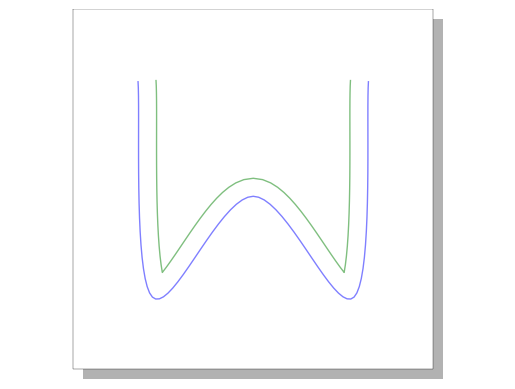

In [14]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(curve_pline)
vsk.stroke(2)
vsk.polygon(offset_pline)
vsk.display()

What we end up with is the original figure, plus a new curve that is offset a particular distance from the original curve. If we draw a number of offsets at increasing distances, we get what resembles a thick line that follows the shape of the original curve:

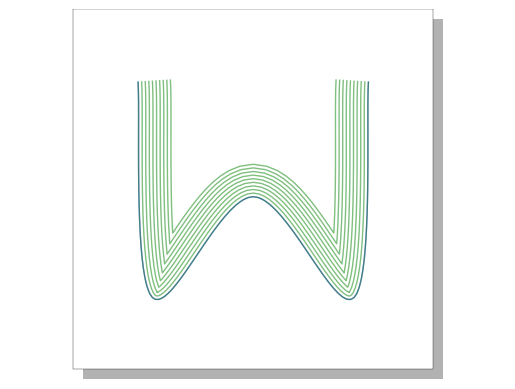

In [15]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(curve_pline)
vsk.stroke(2)
for i in range(10):
    offset_pline = curve_spline.offsets(
        distances=[i*1, i*1], samples_per=24).vertices
    vsk.polygon(offset_pline)
vsk.display()

Unline the linear offsets in the previous section, which resembled the nib of a fountain pen, this curve looks more like a poster marker, where we've turned the tip of the marker to match the tangent of the curve.

The `distances` parameter of `.offsets()` actually lets you specify the distance of the curve offset at various points along the curve. In the following example, I include five elements in this list, which creates a new curve that is variably offset along its length, following the specified parameters. (Bezmerizing interpolates these values for you.)

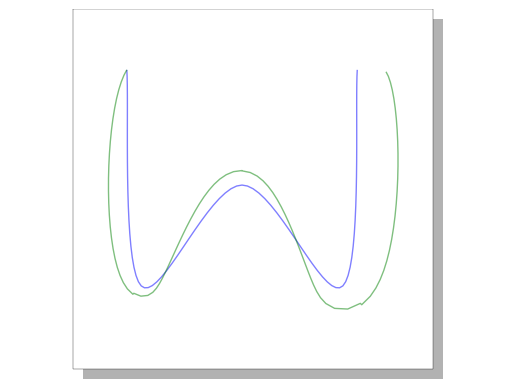

In [16]:
offset_pline = curve_spline.offsets(
    distances=[0, -3, 4, -7, -8], samples_per=24).vertices
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(curve_pline)
vsk.stroke(2)
vsk.polygon(offset_pline)
vsk.display()

You can use this functionality of `.offsets()` in a `for` loop to create repeated strokes that build up more sophisticated line thicknesses. Try varying the values in the `distances` list, and the number of `for` loop iterations:

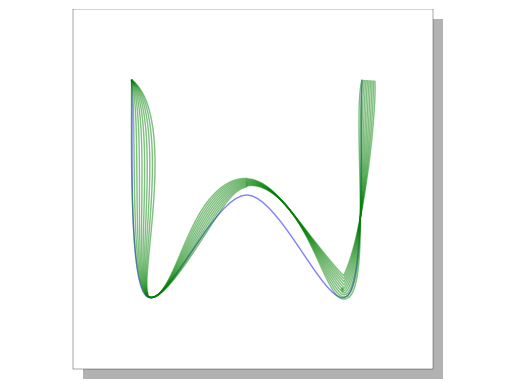

In [17]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(curve_pline)
vsk.stroke(2)
for i in range(10):
    offset_pline = curve_spline.offsets(
        distances=[0, i*0.6, 0, i*0.5, 4, i*0.6, 0, i*-0.4], samples_per=36).vertices
    vsk.polygon(offset_pline)
vsk.display()

(You can, of course, comment out the first call to `.polygon()` if you want to hide the original figure.)

This is a bit more of an advanced example, but I wanted to show it to you anyway. You don't have to write that `distances` list by hand! You can also precalculate it. Here's an example. Using numpy's `linspace` command, I create a list of interpolated numbers from zero to some other number:

In [18]:
np.linspace(0, 12, num=50)

array([ 0.        ,  0.24489796,  0.48979592,  0.73469388,  0.97959184,
        1.2244898 ,  1.46938776,  1.71428571,  1.95918367,  2.20408163,
        2.44897959,  2.69387755,  2.93877551,  3.18367347,  3.42857143,
        3.67346939,  3.91836735,  4.16326531,  4.40816327,  4.65306122,
        4.89795918,  5.14285714,  5.3877551 ,  5.63265306,  5.87755102,
        6.12244898,  6.36734694,  6.6122449 ,  6.85714286,  7.10204082,
        7.34693878,  7.59183673,  7.83673469,  8.08163265,  8.32653061,
        8.57142857,  8.81632653,  9.06122449,  9.30612245,  9.55102041,
        9.79591837, 10.04081633, 10.28571429, 10.53061224, 10.7755102 ,
       11.02040816, 11.26530612, 11.51020408, 11.75510204, 12.        ])

And then calculate the sine of each of those values, creating a list of numbers that oscillates between $-1$ and $1$:

In [19]:
np.sin(np.linspace(0, 12, num=50))

array([ 0.        ,  0.24245733,  0.47044581,  0.67036003,  0.83026995,
        0.94063279,  0.99486256,  0.98972305,  0.92552097,  0.80608763,
        0.63855032,  0.43290697,  0.20142953, -0.0420684 , -0.28305585,
       -0.50715171, -0.70098285, -0.85298224, -0.95407918, -0.99824062,
       -0.9828312 , -0.90877049, -0.78047811, -0.60561003, -0.39460166,
       -0.16004509,  0.08406231,  0.32315322,  0.54295968,  0.73036456,
        0.8741843 ,  0.96583634,  0.99985128,  0.97419922,  0.890411  ,
        0.75348673,  0.57159749,  0.35559768,  0.11837728, -0.12590739,
       -0.36267843, -0.57780632, -0.75845312, -0.89383859, -0.97588346,
       -0.99969166, -0.96384239, -0.870475  , -0.72516127, -0.53657292])

And then use this list to draw a sequence of curve offsets that vary with a loop variable, which gives the impression of a wavy pen stroke. Play around with the parameters to `linspace()` (and the other constants in the expression passed to the `distance` parameter) to create your own variants:

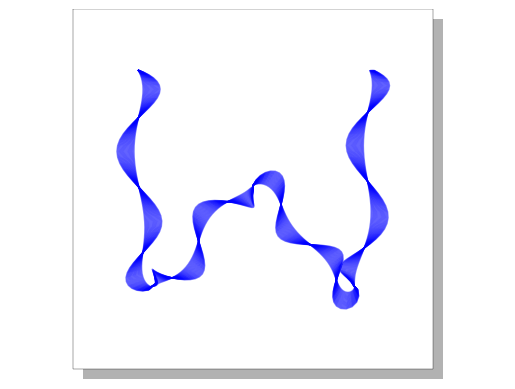

In [20]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
#vsk.polygon(curve_pline)
vsk.stroke(2)
for i in range(20):
    offset_pline = curve_spline.offsets(
        distances=np.sin(np.linspace(0, 50, num=1000))*(i+5)*0.25,
        samples_per=48).vertices
    vsk.polygon(offset_pline)
vsk.display()

## Filling a "Fancy Curve"

The Bezmerizing library also has a `.fancy_curve()` method, which is a variation of the `.offsets()` method. The `.fancy_curve()` calculates two offset curves on either side of the original figure, and combines those curves into a single polygon. You can specify the thickness of the resulting polygon using the `thicknesses` parameter, which works in a manner analogous to `distances` in `.offsets()`. For example, the following cell creates a polygon that follows the points of the original polyline, whose thickness starts at zero and expands gradually to 4:

In [21]:
thick = Polyline(pts).augment().fancy_curve(
    samples_per=10,
    thicknesses=[0, 4]
).vertices

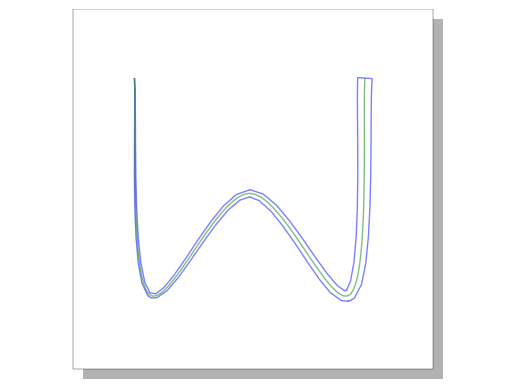

In [22]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(thick, close=True)
vsk.stroke(2)
vsk.polygon(curve_pline)
vsk.display()

As with `.offsets()`, you can specify a list of thicknesses, which will be interpolated along the curve:

In [23]:
thick = Polyline(pts).augment().fancy_curve(
    samples_per=24,
    thicknesses=[0, 2, 6, 2, 4, 2]
).vertices

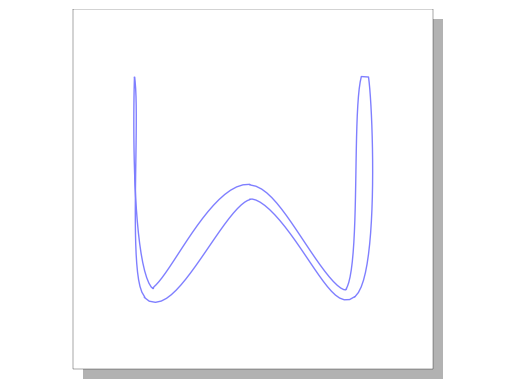

In [24]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.polygon(thick, close=True)
vsk.display()

To turn this into something that looks like a solid stroke, instead of the outline of a polygon, we can "fill" the polygon using vsketch:

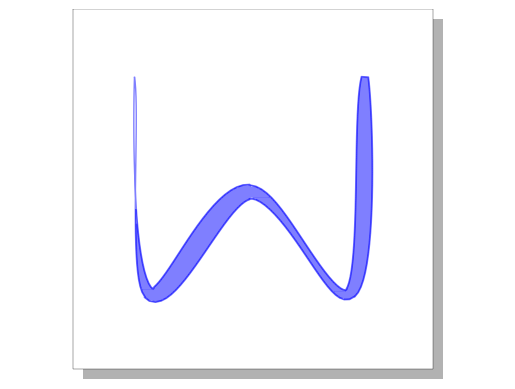

In [25]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.fill(1)
vsk.polygon(thick, close=True)
vsk.display()

As mentioned in previous tutorials, the `.fill()` method of vsketch only *simulates* a fill. It does this by drawing a fine fill pattern within the polygon. This becomes a little bit more apparent in the preview when you increase the pen size:

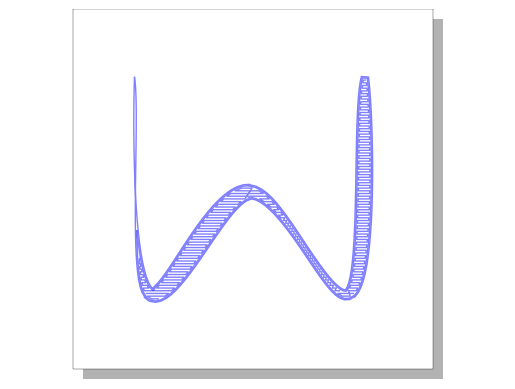

In [26]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.penWidth("0.75mm")
vsk.scale("1mm")
vsk.stroke(1)
vsk.fill(1)
vsk.polygon(thick, close=True)
vsk.display()

## Putting it together

Let's make an asemic composition with these principles! To start, here's a function that generates a polyline with an asemic glyph:

In [27]:
import itertools
def create_figure():
    # a 3x4 grid
    all_pts = list(itertools.product([-1, 0, 1], [-1, 0, 1, 2]))
    # pick some number of points from the grid
    pts = random.sample(all_pts, random.randrange(6, 10))
    return pts

And here's what one of those figures looks like in isolation:

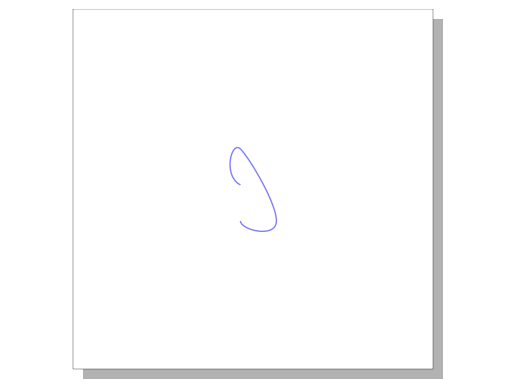

In [28]:
vsk = vsketch.Vsketch()
vsk.size("100mm", "100mm")
vsk.scale("1mm")
vsk.scale(10)
fig = create_figure()
curve = Polyline(fig).catmull_spline(-0.5)
curve_pts = curve.to_polyline(20)
vsk.polygon(curve_pts)
vsk.display()

The following function draws a polyline with the 45-degree nib technique from earlier in the notebook:

In [29]:
def draw_with_nib(vsk, pline):
    for i in range(20):
        with vsk.pushMatrix():
            vsk.translate(i*0.02, i*0.02)
            vsk.polygon(pline)

Now, we'll draw a line of figures using this same style. (You may need to adjust the various scaling values and multipliers to get everything to look like you want.)

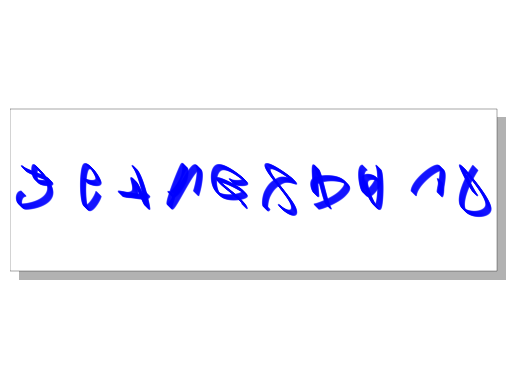

In [30]:
vsk = vsketch.Vsketch()
vsk.size("150mm", "50mm")
vsk.scale("1mm")
for i in range(10):
    fig = create_figure()
    spline = Polyline(fig).catmull_spline(-0.5)
    curve_pts = spline.to_polyline(20)
    with vsk.pushMatrix():
        vsk.translate(i*15, 25)
        vsk.scale(4)
        draw_with_nib(vsk, curve_pts)
vsk.display()

Here's another function, which takes a spline and draws the offset curve:

In [31]:
def draw_with_brush(vsk, curve):
    for i in range(10):
        offset_pline = curve.offsets(
            distances=[0, i*0.03, 0, i*-0.05, 0], samples_per=24).vertices
        vsk.polygon(offset_pline)

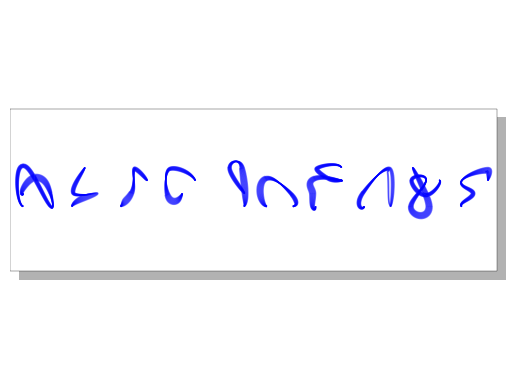

In [32]:
vsk = vsketch.Vsketch()
vsk.size("150mm", "50mm")
vsk.scale("1mm")
for i in range(10):
    fig = create_figure()
    spline = Polyline(fig).catmull_spline(-0.5)
    curve_pts = spline.to_polyline(20)
    with vsk.pushMatrix():
        vsk.translate(i*15, 25)
        vsk.scale(4)
        draw_with_brush(vsk, spline)
vsk.display()

## Conclusion

Hopefully this notebook has given you some interesting ideas! You should be able to apply any of the above techniques to any system for generating figures that results in polylines. Of course, this notebook is not even close to being a thorough or systematic overview of different techniques that you might use to produce organic or painterly strokes from simpler vector or raster figures—if you're interested in this topic, I recommend [this recent review](https://onlinelibrary.wiley.com/doi/full/10.1002/cav.1435) and newer papers that cite it.